In [551]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold

In [552]:
j = 15
k = 15

features = pd.read_csv('daily_j' + str(j) + '_k' + str(k)+'_features.csv')
pct = pd.read_csv('daily_j' + str(j) + '_k' + str(k)+'_pct.csv')

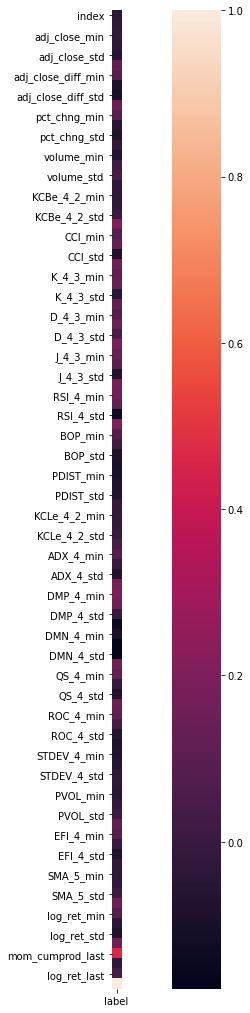

In [553]:
corr = features.corr() 
fig, ax = plt.subplots(figsize = (18, 18)) 
sns.heatmap(corr[['label']], square=True) 

In [554]:
correlated_features = set()
for i in range(len(corr.columns)):
    for a in range(i):
        if abs(corr.iloc[i, a]) > 0.90:
            colname = corr.columns[i]
            correlated_features.add(colname)

In [555]:
num_colums = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(features.select_dtypes(include=num_colums).columns)
df = features[numerical_columns]
df

,index,adj_close_mean,adj_close_min,adj_close_max,adj_close_std,adj_close_diff_mean,adj_close_diff_min,adj_close_diff_max,adj_close_diff_std,pct_chng_mean,...,SMA_5_std,log_ret_mean,log_ret_min,log_ret_max,log_ret_std,cumprod_last,mom_cumprod_last,rev_cumprod_last,log_ret_last,label
0,0,1122.308633,1073.869995,1150.229980,25.659464,-1.412859,-24.719971,15.319946,11.382389,-0.001158,...,21.629749,-0.001206,-0.022390,0.014165,0.009977,-0.026187,0.256955,-0.151536,0.012890,1.0
1,1,1078.873635,1056.739990,1099.510010,15.669354,0.222998,-34.170044,19.359985,14.808026,0.000261,...,5.162906,0.000185,-0.031636,0.017841,0.013029,0.002032,-0.014523,-0.008068,0.004229,0.0
2,2,1109.477498,1094.599976,1122.969971,8.032132,1.474543,-13.410034,11.219971,6.590656,0.001228,...,3.876035,0.001212,-0.012177,0.010107,0.005705,0.014655,-0.000205,0.036021,0.003729,-1.0
3,3,1150.341644,1138.500000,1166.209961,10.435415,1.927279,-5.929932,8.949951,4.151533,0.001544,...,7.602640,0.001537,-0.005099,0.007749,0.003456,0.018618,0.063845,0.078315,-0.005099,0.0
4,4,1170.448893,1165.729980,1178.099976,4.404358,1.536240,-6.450073,8.669922,5.746857,0.001175,...,1.389118,0.001165,-0.005508,0.007386,0.004611,0.010542,0.022072,0.028606,0.007386,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,266,3714.561035,3687.260010,3756.070068,24.007745,4.400011,-55.420166,32.300049,26.165230,0.001089,...,13.535293,0.001068,-0.014865,0.008685,0.006631,0.010740,0.005250,0.051901,0.007058,0.0
267,267,3795.449086,3748.139893,3851.850098,30.968623,10.371021,-27.290039,55.650146,29.543741,0.002509,...,9.352935,0.002481,-0.007216,0.014738,0.007426,0.027670,0.100290,0.067327,0.013839,1.0
268,268,3817.255025,3714.239990,3871.739990,49.245850,1.697266,-98.850098,59.620117,49.838088,0.000475,...,32.240173,0.000403,-0.026013,0.015924,0.012560,0.004845,-0.006481,-0.088584,0.010795,0.0
269,269,3913.288197,3886.830078,3934.830078,16.237726,1.987988,-17.360107,28.760010,13.130949,0.000469,...,10.592979,0.000464,-0.004426,0.007372,0.003188,0.005115,0.026786,0.045989,-0.001857,0.0


In [556]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1), 
                                                    df['label'], train_size=0.538,shuffle=False)
X_before = X_test
X_train = X_train.dropna()
X_test = X_test.dropna()

X_train.drop(columns=correlated_features, axis=1, inplace=True)
X_test.drop(columns=correlated_features, axis=1, inplace=True)


scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

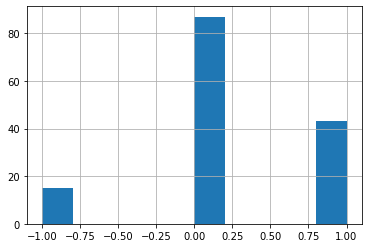

In [557]:
y_train.hist()

In [558]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0,intercept_scaling=1,   
               dual=True, fit_intercept=True, penalty='l2'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
clf.fit(X_train,y_train)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [559]:
predictions = clf.predict(X_test)
predictions

array([ 0.,  1.,  0.,  1.,  1.,  1.,  0., -1.,  1.,  1.,  0.,  0.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.])

In [560]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        -1.0       1.00      0.07      0.13        14
         0.0       0.73      0.51      0.60        75
         1.0       0.48      0.95      0.64        37

    accuracy                           0.59       126
   macro avg       0.74      0.51      0.46       126
weighted avg       0.69      0.59      0.56       126



In [561]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Cross-Validation Accuracy Scores [0.8        0.6        0.8        0.86666667 0.6        0.78571429
 0.78571429 0.64285714 0.57142857 0.92857143]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [562]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.5714285714285714, 0.7380952380952381, 0.9285714285714286)

In [563]:
X_before['label'] = predictions.tolist()

In [564]:
performance =pct[['date','index', 'mom_pct_change','rev_pct_change','SP500_pct_change']].infer_objects()
performance['date'] = pd.to_datetime(performance['date'])
# output = date.merge(performance, how='right',left_index=True, right_index=True)[['date','index', 'mom_pct_change','rev_pct_change','SP500_pct_change']]
# output
# output.to_csv(csv_)
performance = performance.set_index('date')
performance = performance.merge(X_before[['label']], left_on='index', right_index=True) #example
performance['test_pct_change'] = performance.apply(lambda x: x['mom_pct_change'] if x['label']==1 else x['rev_pct_change'] if x['label']==-1 else 0,axis=1) # todo build more models and get their outputs. output results here

performance[['mom_return','rev_return', 'test_return']] = performance[['mom_pct_change','rev_pct_change', 'test_pct_change']].apply(lambda x: (x+1).cumprod()-1)*100
#performance[['mom_return','rev_return', 'test_return']] = performance[['mom_pct_change','rev_pct_change', 'test_pct_change']].apply(lambda x: np.log(1 + x).cumsum())
performance
performance[['mom_return_diff','rev_return_diff', 'test_return_diff']] = performance[['mom_pct_change','rev_pct_change', 'test_pct_change']].diff()
performance['mom_sharpe_ratio'] = performance['mom_return'].mean()/performance['mom_return'].std() * np.sqrt(252)

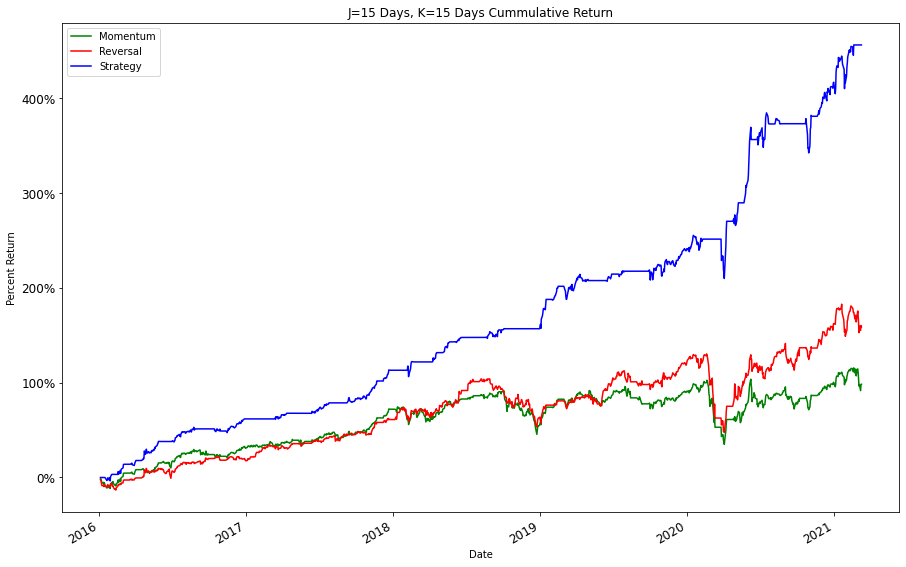

In [565]:
import matplotlib.ticker as mtick

plt = performance[['mom_return','rev_return', 'test_return']].plot(figsize=(15,10),title='J={0} Days, K={1} Days Cummulative Return'.format(j,k),xlabel="Date",ylabel="Percent Return",fontsize=12,color=['green','red','blue'])
plt.legend(['Momentum','Reversal','Strategy'])
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
plt.yaxis.set_major_formatter(yticks)
plt.get_figure().savefig('lr_performance_j{0}_k{1}.png'.format(j,k))